In [1]:
import numpy as np
import pandas as pd

import os
# for dirname, _, filenames in os.walk('C:/Universitetas/Kursinis/Dataset/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
import glob
import shutil
import cv2
import os
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import Input

%matplotlib inline
plt.rcParams["figure.figsize"] = (17, 6) # (w, h)

In [3]:
TRAINING_DIR = "C:/Universitetas/Kursinis/Dataset/train_images/"
TRAINING_CSV = "C:/Universitetas/Kursinis/Dataset/train.csv"
JSON_LABELS = "C:/Universitetas/Kursinis/Dataset/label_num_to_disease_map.json"
# PRETRAINED_MODEL = "C:/Universitetas/Kursinis/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [4]:
train_df = pd.read_csv(TRAINING_CSV)
train_df["label"] = train_df["label"].astype("string")

In [5]:
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
total_images_count = len(train_df.index)
total_train_img_count = int(len(train_df.index) * 0.8)
total_val_img_count = total_images_count - total_train_img_count
print("\nIš viso paveiksliukų: {}".format(total_images_count))
print("Paveiksliukai mokymui: {}".format(total_train_img_count))
print("Paveiksliukai validavimui: {}".format(total_val_img_count))



Iš viso paveiksliukų: 21397
Paveiksliukai mokymui: 17117
Paveiksliukai validavimui: 4280


In [7]:
label_df = pd.read_json(JSON_LABELS, orient = 'index')
label_df = label_df.values.flatten().tolist()
label_df

['Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy']

In [8]:
train_label_0 = train_df[train_df["label"]== "0"]
train_label_1 = train_df[train_df["label"]== "1"]
train_label_2 = train_df[train_df["label"]== "2"]
train_label_3 = train_df[train_df["label"]== "3"]
train_label_4 = train_df[train_df["label"]== "4"]
len(train_label_4)

2577

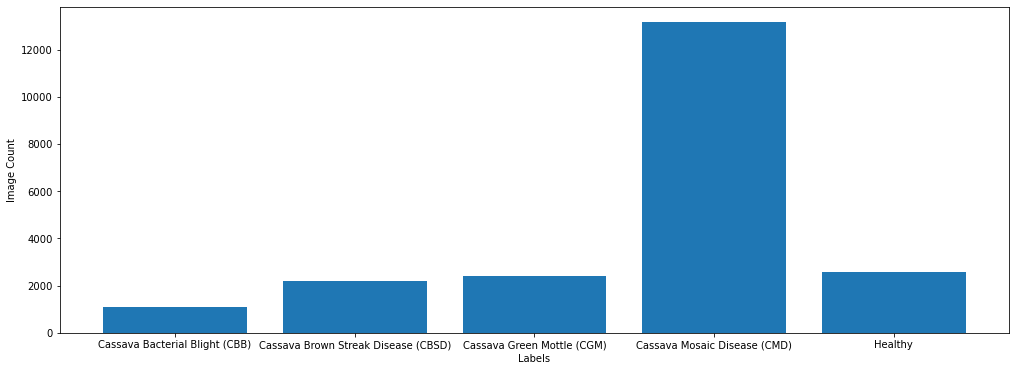

In [9]:
len_by_labels = [
    len(train_label_0),
    len(train_label_1),
    len(train_label_2),
    len(train_label_3),
    len(train_label_4),
]

plt.bar(label_df, len_by_labels)

plt.xlabel('Labels')  
plt.ylabel('Image Count')

plt.show()  

In [10]:
training_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 100,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.3,
    brightness_range = [0.7, 1.4],
    horizontal_flip = True,
    vertical_flip=True,
    fill_mode = "nearest",
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale = 1/255,
    validation_split=0.2
)

In [11]:
BATCH_SIZE = 24
IMG_WIDTH = 300
IMG_HEIGHT = 300
CHANNEL = 3

print("\nMokymo rinkinys")
train_ds = training_datagen.flow_from_dataframe(
    train_df,
    TRAINING_DIR,
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    x_col = "image_id",
    y_col = "label",
    shuffle = True,
    subset = "training"

)
print("\nValidacijos rinkinys")
validation_ds = validation_datagen.flow_from_dataframe(
    train_df,
    TRAINING_DIR,
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    x_col = "image_id",
    y_col = "label",
    shuffle = False,
    subset = "validation"
)
# print("\nClass Indices:")
# print(train_ds.class_indices)


Mokymo rinkinys
Found 17118 validated image filenames belonging to 5 classes.

Validacijos rinkinys
Found 4279 validated image filenames belonging to 5 classes.


In [12]:
reduce_lr = ReduceLROnPlateau(
                    monitor='val_loss', 
                    factor=0.5,
                    patience= 2, 
                    verbose = 1,
                    cooldown = 1,
                    min_lr=0.0001)

In [13]:
loss_func = CategoricalCrossentropy()
optimizer = Adam(learning_rate=0.001)

In [14]:
model_checkpoint_path="./InceptionResNetV208.h5"
checkpoint = ModelCheckpoint(model_checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True,mode='max')

In [15]:
new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNEL))

In [16]:
base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=new_input,
)
base_model.trainable = True

In [17]:
def create_model():

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(5, activation = "softmax"))

    return model

In [18]:
model = create_model()

model.compile(
    optimizer=optimizer,
    loss = loss_func,
    metrics = ["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 7685      
Total params: 54,344,421
Trainable params: 54,283,877
Non-trainable params: 60,544
_________________________________________________________________


In [19]:
num_epochs = 10
steps_per_epoch = total_train_img_count // BATCH_SIZE

In [20]:
history = model.fit(
    train_ds,
    epochs = num_epochs,
    validation_data = validation_ds,
    verbose = 1,
    steps_per_epoch = steps_per_epoch,
    callbacks = [
        reduce_lr,
        checkpoint
                ]
)

Epoch 1/10
713/713 [==============================] - 478s 639ms/step - loss: 0.7298 - accuracy: 0.7399 - val_loss: 0.6372 - val_accuracy: 0.7775

Epoch 00001: val_accuracy improved from -inf to 0.77752, saving model to .\InceptionResNetV208.h5
Epoch 2/10
713/713 [==============================] - 455s 637ms/step - loss: 0.6012 - accuracy: 0.7869 - val_loss: 0.6163 - val_accuracy: 0.7859

Epoch 00002: val_accuracy improved from 0.77752 to 0.78593, saving model to .\InceptionResNetV208.h5
Epoch 3/10
713/713 [==============================] - 449s 629ms/step - loss: 0.5484 - accuracy: 0.8069 - val_loss: 0.4955 - val_accuracy: 0.8292

Epoch 00003: val_accuracy improved from 0.78593 to 0.82917, saving model to .\InceptionResNetV208.h5
Epoch 4/10
713/713 [==============================] - 453s 635ms/step - loss: 0.5238 - accuracy: 0.8195 - val_loss: 0.5431 - val_accuracy: 0.8161

Epoch 00004: val_accuracy did not improve from 0.82917
Epoch 5/10
713/713 [==============================] - 455

In [24]:
# model.save("./InceptionResNetV208.h5")


In [21]:
import pickle

In [22]:
with open('./InceptionResNetV208history', 'wb') as file:
    pickle.dump(history.history, file)

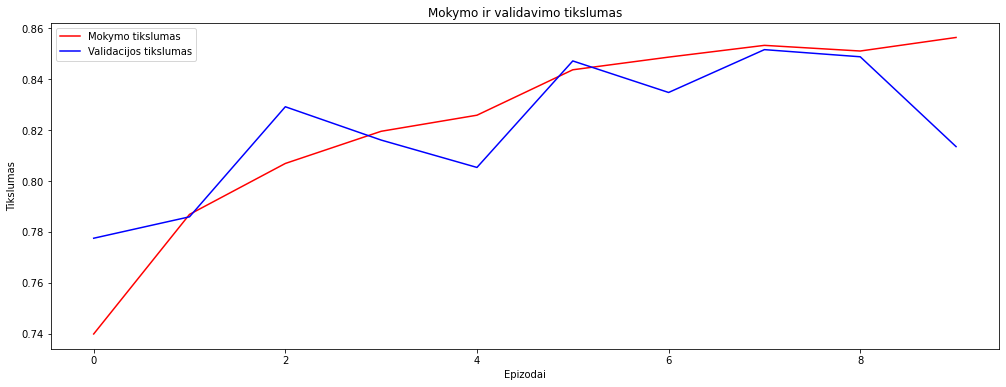

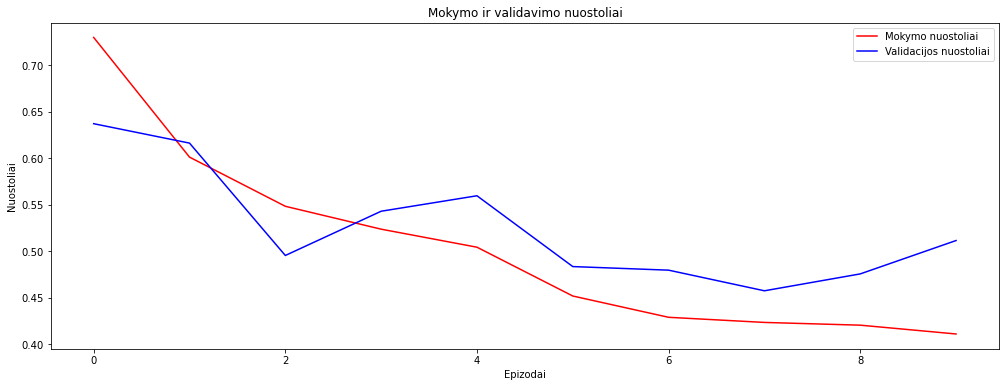

<Figure size 1224x432 with 0 Axes>

In [23]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Mokymo tikslumas")
plt.plot(epochs, val_acc, "b", label="Validacijos tikslumas")
plt.title("Mokymo ir validavimo tikslumas")
plt.xlabel("Epizodai")
plt.ylabel("Tikslumas")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "r", label="Mokymo nuostoliai")
plt.plot(epochs, val_loss, "b", label="Validacijos nuostoliai")
plt.title("Mokymo ir validavimo nuostoliai")
plt.xlabel("Epizodai")
plt.ylabel("Nuostoliai")
plt.legend()
plt.figure()

plt.show()

In [25]:
import tensorflow as tf

model = tf.keras.models.load_model("./InceptionResNetV208.h5")
predicted = []
sample_submission = pd.read_csv('C:/Universitetas/Kursinis/Dataset/sample_submission.csv')

for image in sample_submission.image_id:
    img = tf.keras.preprocessing.image.load_img('C:/Universitetas/Kursinis/Dataset/test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = tf.reshape(img, (-1, IMG_WIDTH, IMG_HEIGHT, CHANNEL))
    prediction = model.predict(img/255)  
    predicted.append(np.argmax(prediction))

submission = pd.DataFrame({'image_id': sample_submission.image_id, 'label': predicted})
# submission.to_csv('submission.csv', index=False) 

In [26]:
submission

,image_id,label
0,2216849948.jpg,4
